In [1]:
from datasets import load_dataset

d:\Projects\Tradeformers\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
dataset = load_dataset("monash_tsf", "tourism_monthly")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [26]:
train_example = dataset['train'][0]
validation_example = dataset['validation'][0]

In [27]:
train_example

{'start': datetime.datetime(1979, 1, 1, 0, 0),
 'target': [1149.8699951171875,
  1053.8001708984375,
  1388.8797607421875,
  1783.3702392578125,
  1921.025146484375,
  2704.94482421875,
  4184.41357421875,
  4148.35400390625,
  2620.72509765625,
  1650.300048828125,
  1115.9200439453125,
  1370.6251220703125,
  1096.31494140625,
  978.4600219726562,
  1294.68505859375,
  1480.465087890625,
  1748.865234375,
  2216.920166015625,
  4690.5185546875,
  4682.8642578125,
  2459.579833984375,
  1484.4901123046875,
  1028.985107421875,
  1109.3648681640625,
  960.8751220703125,
  896.35009765625,
  1118.6551513671875,
  1619.9949951171875,
  1847.994873046875,
  2367.044921875,
  4991.16015625,
  4772.9443359375,
  2894.678466796875,
  1860.4801025390625,
  1185.150146484375,
  1313.659912109375,
  1160.9150390625,
  1061.5048828125,
  1301.77001953125,
  1794.3797607421875,
  2106.455078125,
  2789.034912109375,
  4917.8466796875,
  4994.4833984375,
  3016.754150390625,
  1941.505126953125,
 

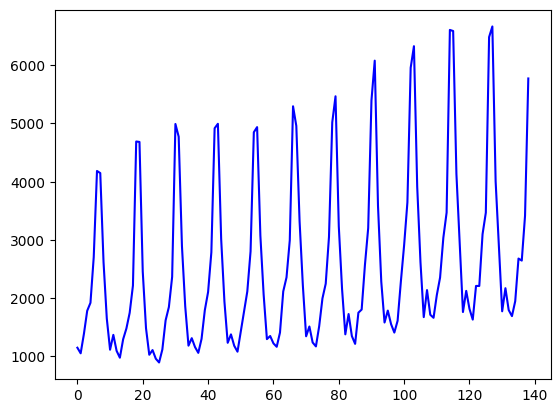

In [53]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")

In [3]:
freq = "1M"
prediction_length = 24

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

NameError: name 'train_example' is not defined

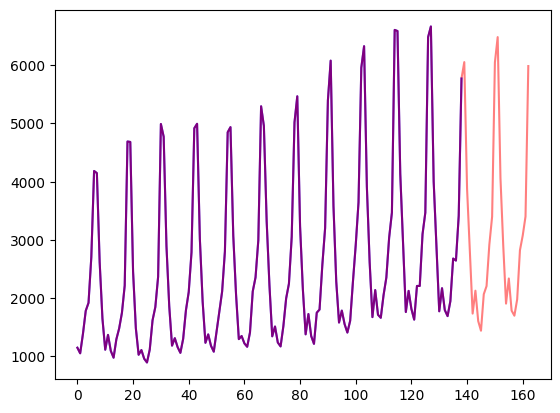

In [7]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()

In [28]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [31]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})

In [36]:
for i in train_dataset['item_id']:
    print(i)

T1
T2
T3
T4
T5
T6
T7
T8
T9
T10
T11
T12
T13
T14
T15
T16
T17
T18
T19
T20
T21
T22
T23
T24
T25
T26
T27
T28
T29
T30
T31
T32
T33
T34
T35
T36
T37
T38
T39
T40
T41
T42
T43
T44
T45
T46
T47
T48
T49
T50
T51
T52
T53
T54
T55
T56
T57
T58
T59
T60
T61
T62
T63
T64
T65
T66
T67
T68
T69
T70
T71
T72
T73
T74
T75
T76
T77
T78
T79
T80
T81
T82
T83
T84
T85
T86
T87
T88
T89
T90
T91
T92
T93
T94
T95
T96
T97
T98
T99
T100
T101
T102
T103
T104
T105
T106
T107
T108
T109
T110
T111
T112
T113
T114
T115
T116
T117
T118
T119
T120
T121
T122
T123
T124
T125
T126
T127
T128
T129
T130
T131
T132
T133
T134
T135
T136
T137
T138
T139
T140
T141
T142
T143
T144
T145
T146
T147
T148
T149
T150
T151
T152
T153
T154
T155
T156
T157
T158
T159
T160
T161
T162
T163
T164
T165
T166
T167
T168
T169
T170
T171
T172
T173
T174
T175
T176
T177
T178
T179
T180
T181
T182
T183
T184
T185
T186
T187
T188
T189
T190
T191
T192
T193
T194
T195
T196
T197
T198
T199
T200
T201
T202
T203
T204
T205
T206
T207
T208
T209
T210
T211
T212
T213
T214
T215
T216
T217
T218
T219
T220
T221
T22

In [5]:
from functools import lru_cache

import pandas as pd
import numpy as np


def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [6]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [15]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})

In [51]:
print(len(test_dataset[0]['target']))
print(len(test_dataset[5]['target']))

187
264


In [49]:
i = 0
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    print(len(training_data))
    i = i + 1
    if (i > 5): break

163
163
240
240
240
240


In [45]:
train_dataset[0]['target']

[1149.8699951171875,
 1053.8001708984375,
 1388.8797607421875,
 1783.3702392578125,
 1921.025146484375,
 2704.94482421875,
 4184.41357421875,
 4148.35400390625,
 2620.72509765625,
 1650.300048828125,
 1115.9200439453125,
 1370.6251220703125,
 1096.31494140625,
 978.4600219726562,
 1294.68505859375,
 1480.465087890625,
 1748.865234375,
 2216.920166015625,
 4690.5185546875,
 4682.8642578125,
 2459.579833984375,
 1484.4901123046875,
 1028.985107421875,
 1109.3648681640625,
 960.8751220703125,
 896.35009765625,
 1118.6551513671875,
 1619.9949951171875,
 1847.994873046875,
 2367.044921875,
 4991.16015625,
 4772.9443359375,
 2894.678466796875,
 1860.4801025390625,
 1185.150146484375,
 1313.659912109375,
 1160.9150390625,
 1061.5048828125,
 1301.77001953125,
 1794.3797607421875,
 2106.455078125,
 2789.034912109375,
 4917.8466796875,
 4994.4833984375,
 3016.754150390625,
 1941.505126953125,
 1234.135009765625,
 1378.72021484375,
 1182.9749755859375,
 1081.6600341796875,
 1424.110107421875,
 17

In [42]:
for item in train_dataset:
    target_ndim = np.ndim(item['feat_dynamic_real'])
    print(f"Target ndim: {target_ndim}")

Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndim: 0
Target ndi

In [11]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [12]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x0000016FFF382D40>]


In [13]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1081113521.py, line 4)

In [ ]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [ ]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [ ]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [ ]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [ ]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [ ]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 85, 2]) torch.FloatTensor
past_values torch.Size([256, 85]) torch.FloatTensor
past_observed_mask torch.Size([256, 85]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.IntTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


In [ ]:
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [ ]:
print("Loss:", outputs.loss.item())

Loss: 8.994379997253418


In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

8.764802932739258
7.8872456550598145
7.536228656768799
7.042825698852539
7.76854944229126
7.361985683441162
7.514244079589844
7.0834808349609375
6.85528564453125
7.113729000091553
7.3287739753723145
6.713233470916748
6.631333827972412
7.633105754852295
7.550378322601318
7.092878818511963
7.1875762939453125
6.687663555145264
6.889214038848877
7.5724358558654785
7.041861057281494
7.515440464019775
7.50372314453125
6.828418731689453
7.463823318481445
7.336967468261719
7.431158542633057
7.618518829345703
6.985589504241943
7.009815216064453
7.63316011428833
7.2796759605407715
7.017212390899658
7.334280490875244
6.975898265838623
7.142742156982422
6.891022205352783
7.596054553985596
7.437870025634766
6.8511786460876465


In [ ]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [ ]:
forecasts[0].shape

(64, 100, 24)

In [ ]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])

In [ ]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

MASE: 1.5455154103624875
sMAPE: 0.19493682976843346


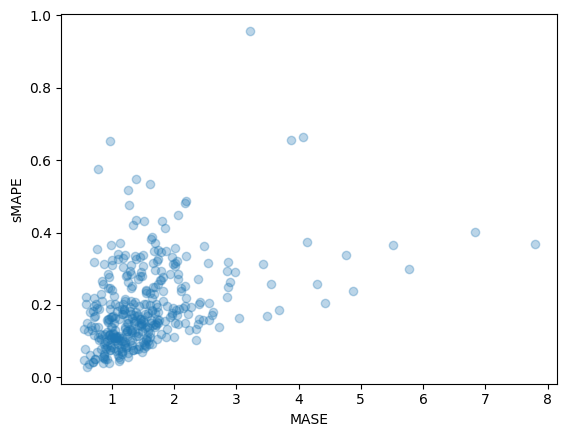

In [ ]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [ ]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

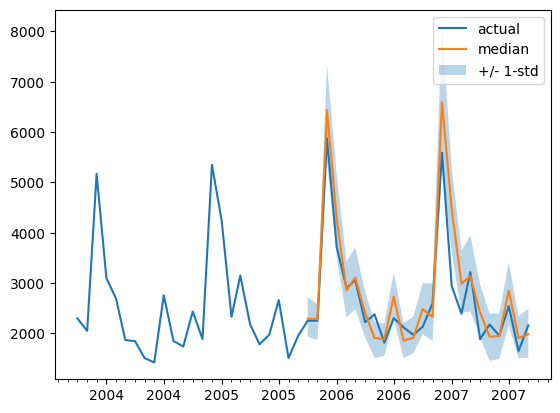

In [ ]:
plot(334)

In [ ]:
test_dataset[30]

{'start': Period('1980-01', 'M'),
 'target': [2777.0,
  4699.0,
  3927.0,
  1725.0,
  1242.0,
  1347.0,
  1573.0,
  999.0,
  1311.0,
  2124.0,
  2822.0,
  3953.0,
  3229.0,
  3384.0,
  3948.0,
  2281.0,
  1648.0,
  1357.0,
  2200.0,
  1838.0,
  1761.0,
  2647.0,
  2856.0,
  3821.0,
  3199.0,
  3077.0,
  3155.0,
  2768.0,
  2015.0,
  1487.0,
  2367.0,
  2339.0,
  2725.0,
  2883.0,
  2771.0,
  3700.0,
  3352.0,
  3486.0,
  2720.0,
  2920.0,
  1619.0,
  1357.0,
  2838.0,
  2711.0,
  1950.0,
  2820.0,
  3101.0,
  4188.0,
  3723.0,
  3979.0,
  3388.0,
  3330.0,
  1933.0,
  1448.0,
  2684.0,
  2156.0,
  1753.0,
  2847.0,
  3372.0,
  3944.0,
  4052.0,
  3862.0,
  4149.0,
  4203.0,
  2255.0,
  1576.0,
  2460.0,
  2175.0,
  2079.0,
  3349.0,
  5403.0,
  5373.0,
  4801.0,
  4963.0,
  3951.0,
  4117.0,
  2212.0,
  1718.0,
  2842.0,
  2847.0,
  2489.0,
  4149.0,
  6595.0,
  6306.0,
  5090.0,
  5479.0,
  4404.0,
  4838.0,
  2599.0,
  2526.0,
  3129.0,
  2717.0,
  3089.0,
  4731.0,
  7364.0,
  6797.